# 获取原始数据

In [1]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.20.88:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_3000", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata

,timestamp,sqrtPriceX96,price,datetime
0,1620609472,1267554519342589161168659854845874,0.000256,2021-05-10 01:17:52
1,1620609830,1267498129839936824485169221023868,0.000256,2021-05-10 01:23:50
2,1620609889,1267496927736336268048970777338285,0.000256,2021-05-10 01:24:49
3,1620609889,1267496466129159558106023913391909,0.000256,2021-05-10 01:24:49
4,1620609894,1267269382521328460205280017540103,0.000256,2021-05-10 01:24:54
...,...,...,...,...
153322,1636505287,1151304179731807924804200863381341,0.000211,2021-11-10 00:48:07
153323,1636505306,1153213095406308275655367738380110,0.000212,2021-11-10 00:48:26
153324,1636505306,1153226560737155904671591020768514,0.000212,2021-11-10 00:48:26
153325,1636505306,1153227466349991390439811165863993,0.000212,2021-11-10 00:48:26


In [2]:
pricedata['datetime'].tolist()[0]

'2021-05-10 01:17:52'

<AxesSubplot:xlabel='datetime'>

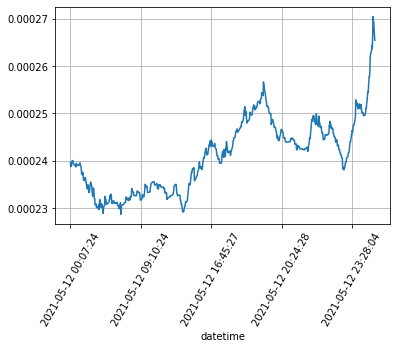

In [3]:
pricedata_plot = pricedata.copy(deep=True)
pricedata_plot = pricedata_plot[pricedata_plot['datetime']<'2021-05-13 00:00:00']
pricedata_plot = pricedata_plot[pricedata_plot['datetime']>'2021-05-12 00:00:00']
pricedata_plot = pricedata_plot[pricedata_plot['datetime']>'2021-05-12 00:00:00']
pricedata_plot.set_index('datetime')['price'].plot(rot = 60,grid=True)
# pricedata_plot.set_index('datetime')['price'].plot(rot = 60)
# pricedata_plot[pricedata_plot['datetime']<'2021-05-15 00:00:00'].set_index('datetime')['price'].plot(rot = 60)

# 指标计算arRollNorm

In [4]:
import pickle
from scipy import stats
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
symbolSigDataAR = load_obj('ARdata/symbolsSigAvg_2018050120211124_60min_v18_ar')['60min']

# AR Rolling Normalization ####################################################
def normalizationProcess(dataArray):
    q75 = np.quantile(dataArray, 0.75)
    q50 = np.quantile(dataArray, 0.5)
    q25 = np.quantile(dataArray, 0.25)
    scaleResult = 100*stats.norm.cdf(0.5*(dataArray[-1]-q50)/(q75-q25))-50
    return scaleResult

def get_ar_norm(df,arCol,WinSize):
    arRollNorm = df[arCol].dropna().rolling(WinSize).apply(normalizationProcess)
    return arRollNorm

ar_param = 144
winsize = 288
symbolSigDataAR[f'arRollNorm{winsize}'] = get_ar_norm(symbolSigDataAR,f'ar{ar_param}',winsize)

startInd = f'{d1.year}-{d1.month}-{d1.day}'
symbolSigDataARRollNorm = symbolSigDataAR.loc[startInd:]
symbolSigDataARRollNormSub = symbolSigDataARRollNorm.reset_index()[[('timestamp',''),(f'arRollNorm{winsize}','')]]
symbolSigDataARRollNormSub.columns = ['datetime',f'arRollNorm{winsize}']
symbolSigDataARRollNormSub['price'] = [np.nan]*len(symbolSigDataARRollNormSub)
symbolSigDataARRollNormSub['sqrtPriceX96'] = [np.nan]*len(symbolSigDataARRollNormSub)
symbolSigDataARRollNormSub['timestamp'] = [np.nan]*len(symbolSigDataARRollNormSub)
symbolSigDataARRollNormSub = symbolSigDataARRollNormSub[['timestamp','sqrtPriceX96','price','datetime',f'arRollNorm{winsize}']]
symbolSigDataARRollNormSub.index = [i for i in range(len(pricedata),len(pricedata)+len(symbolSigDataARRollNormSub))]
symbolSigDataARRollNormSub

pricedataExtend = pricedata.copy(deep=True)
pricedataExtend[f'arRollNorm{winsize}'] = [np.nan]*len(pricedataExtend)
pricedataExtend

datetimeTmp = symbolSigDataARRollNormSub['datetime'].tolist()
datetimeNew = [str(dt)[:-6] for dt in datetimeTmp]
symbolSigDataARRollNormSub['datetime'] = datetimeNew
bar = pricedataExtend.append(symbolSigDataARRollNormSub)

bar = bar.sort_values(by='datetime')
# bar.fillna(method='ffill')
bar = bar.fillna(method='ffill')
pricedata_res_arRollNorm = bar.loc[pricedataExtend.index]
pricedata_res_arRollNorm.set_index('datetime',inplace=True)
pricedata_res_arRollNorm = pricedata_res_arRollNorm[[f'arRollNorm{winsize}']]
pricedata_res_arRollNorm

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
#之后要扩展回测区间时，需要更新此处的基本行情数据
df_eth = load_obj('../../data/usdceth/symbolsData_2018032120211116_60min_v16_E')['60min']
df_eth.columns= ['open','high','low','close','volume']
df_eth = df_eth.loc['2018-03-22':'2021-11-09']
df_eth.reset_index(inplace=True)
df_eth.columns = ['datetime','open','high','low','close','volume']
def cal_indicator(dataCoin):    
    dataCoin['pctChange'] = dataCoin['close'].pct_change()
    dataCoin['pctStd'] = ta.STDDEV(dataCoin['pctChange'], 24*5)*(24**0.5)
    dataCoin['pctStdVma'] = ta.SUM(dataCoin['pctStd']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['closeVma'] = ta.SUM(dataCoin['close']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['pctStdVSma'] = ta.EMA(dataCoin.pctStdVma, 24*3)
    dataCoin['pctStdVLma'] = ta.MA(dataCoin.pctStdVma, 24*10)
    dataCoin['SmaLowerLma'] = dataCoin['pctStdVSma']<dataCoin['pctStdVLma']
    dataCoin['CloseLowerMA'] = dataCoin['close'] < dataCoin['closeVma']
    #根据volResearch notebook里的BelowMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolLowerBelowmaQuantile50'] = dataCoin['pctStd'] < 0.035857 
    #根据volResearch notebook里的OverMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolHigherOvermaQuantile50Twosigma'] = dataCoin['pctStd'] > (0.038511 + 2*0.018451)
    #当波动率高于Belowma的vol stat中的Quantile50的1.05倍时撤销池子
    dataCoin['revoke_pos'] = dataCoin['pctStd'] > 0.035857 *1.05
    
cal_indicator(df_eth)

df_eth_test_period = df_eth[df_eth['datetime']>parse('2021-05-10 00:00:00+00:00')]
df_signal_tmp = df_eth_test_period[['datetime',
                               'SmaLowerLma',
                               'VolLowerBelowmaQuantile50',
                               'CloseLowerMA',
                               'VolHigherOvermaQuantile50Twosigma',
                               'revoke_pos']]
df_signal_tmp['timestamp'] = [0]*len(df_signal_tmp)
df_signal_tmp['sqrtPriceX96'] = [0]*len(df_signal_tmp)
df_signal_tmp['price'] = [0]*len(df_signal_tmp)

df_signal_tmp = df_signal_tmp[['timestamp','sqrtPriceX96','price','datetime',
                 'SmaLowerLma',
                 'VolLowerBelowmaQuantile50',
                 'CloseLowerMA',
                 'VolHigherOvermaQuantile50Twosigma',
                 'revoke_pos']]
df_signal_tmp['datetime_2'] = df_signal_tmp['datetime']
df_signal_tmp = df_signal_tmp.set_index('datetime_2')
# df_signal_tmp = df_signal_tmp.resample('D').first()
df_signal_tmp['datetime'] = [str(tmp)[:-6] for tmp in df_signal_tmp['datetime'].tolist()]
df_signal_tmp['ind'] = [i for i in range(len(pricedata),len(pricedata)+len(df_signal_tmp))]
df_signal_tmp.set_index('ind',inplace=True)
pricedata_tmp = pricedata.append(df_signal_tmp)
pricedata_tmp = pricedata_tmp.sort_values(by='datetime')
pricedata_tmp_beforefill = pricedata_tmp.copy(deep = True)
pricedata_tmp = pricedata_tmp.fillna(method = 'ffill')
pricedata_res = pricedata_tmp.loc[pricedata.index]
pricedata_res.set_index('datetime',inplace=True)

pricedata_res[f'arRollNorm'] = pricedata_res_arRollNorm[f'arRollNorm{winsize}']
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerBelowmaQuantile50,CloseLowerMA,VolHigherOvermaQuantile50Twosigma,revoke_pos,arRollNorm
datetime,,,,,,,,,
2021-05-10 01:17:52,1620609472,1267554519342589161168659854845874,0.000256,False,False,False,False,True,-15.211088
2021-05-10 01:23:50,1620609830,1267498129839936824485169221023868,0.000256,False,False,False,False,True,-15.211088
2021-05-10 01:24:49,1620609889,1267496927736336268048970777338285,0.000256,False,False,False,False,True,-15.211088
2021-05-10 01:24:49,1620609889,1267496466129159558106023913391909,0.000256,False,False,False,False,True,-15.211088
2021-05-10 01:24:54,1620609894,1267269382521328460205280017540103,0.000256,False,False,False,False,True,-15.211088
...,...,...,...,...,...,...,...,...,...
2021-11-10 00:48:07,1636505287,1151304179731807924804200863381341,0.000211,True,True,False,False,False,-43.820580
2021-11-10 00:48:26,1636505306,1153213095406308275655367738380110,0.000212,True,True,False,False,False,-43.820580
2021-11-10 00:48:26,1636505306,1153226560737155904671591020768514,0.000212,True,True,False,False,False,-43.820580


# 回测

In [5]:
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 0.0002559611947100053


# 建池撤池详细信息

In [6]:
import Strategy_usdceth_ar
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_usdceth_ar)
strategy = Strategy_usdceth_ar.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Over MA】【创建Long Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  449725000000.0 amount1:  193724333542227705856
price:  0.00035234281698993356
$$$$$$$【Upper Price】: 0.00045434307427215024
$$$$$$$【Lower Price】: 0.00027324167069847096
######【L】:71573436535275952【USDC】:449725000000【ETH】:163171887593486319616
将要投入池子的数量 amount_t0: 449724999999 amount_t1: 163171887593486319616
【RealWorldTime】:2021-06-04 06:52:40, Timestamp: 1622760760, Blocknumber: 12564328
Mint position： Position(L=71542511970920064, tick=[194220, 199320], range=[2208.3870, 3677.5136])
【Mint amount】: token0=449330.586173, token1=163.17188759348633
Wallet amount: token0=394.413827, token1=30.552445948741386
******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: True, VolHigherQuantile50TwoSigma: False,arRollNorm:-5.380010306121477
Price(0.00035002028520071004) out of range(0.00027324167069847096, 0.

**********************【Price Over MA】【创建Long Vol池子】【第9次建池】***********************************
转换后钱包中余额 amount0:  519442602806.0 amount1:  197078867072414721410
price:  0.00029874921262454363
$$$$$$$【Upper Price】: 0.00038523457597291496
$$$$$$$【Lower Price】: 0.00023167985848201704
######【L】:75278985965060704【USDC】:519442602806【ETH】:156314276026777141248
将要投入池子的数量 amount_t0: 519442602805 amount_t1: 156314276026777141248
【RealWorldTime】:2021-08-23 11:53:59, Timestamp: 1629690839, Blocknumber: 13079274
Mint position： Position(L=75251323744440128, tick=[192600, 197700], range=[2596.7334, 4324.2070])
【Mint amount】: token0=519059.450877, token1=156.31427602677715
Wallet amount: token0=383.151929, token1=40.76459104563758
******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: False, VolHigherQuantile50TwoSigma: False,arRollNorm:5.937236525245737
Price(0.00029115850639098505) out of range(0.00023167985848201704, 0.0

Price(0.00024669378616567556) out of range(0.00018958204401009607, 0.0003152348193530026)
【RealWorldTime】:2021-10-22 01:55:59,Timestamp: 1634838959, Blocknumber: 13462493
Decreased position： Position(L=0, tick=[190560, 195660], range=[3184.3369, 5302.7130])
【Decreased amount】: token0=561485.333337, token1=153.13496729365417
Wallet amount: token0=567269.263461, token1=184.16867703428596
撤池后经转换 Wallet amount: token0=1276078.75449, token1=9.121329095414826
**********************【Price Over MA】【创建Long Vol池子】【第20次建池】***********************************
转换后钱包中余额 amount0:  573884517864.0 amount1:  169086226799709667373
price:  0.00022811171123522588
$$$$$$$【Upper Price】: 0.00029414811701143477
$$$$$$$【Lower Price】: 0.00017690051301820934
######【L】:72757938902769264【USDC】:573884517864【ETH】:132166184804227006464
将要投入池子的数量 amount_t0: 573884517864 amount_t1: 132166184804227006464
【RealWorldTime】:2021-10-30 08:40:09, Timestamp: 1635554409, Blocknumber: 13515371
Mint position： Position(L=72754345248

# 获取原始绩效指标

In [7]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x1a74b0a7fd0>,
 2: <univ3api.simulation.PositionReport at 0x1a74b0c22b0>,
 3: <univ3api.simulation.PositionReport at 0x1a74b0bb630>,
 4: <univ3api.simulation.PositionReport at 0x1a74b0bbd68>,
 5: <univ3api.simulation.PositionReport at 0x1a74b0bb1d0>,
 6: <univ3api.simulation.PositionReport at 0x1a74b0bbc50>,
 7: <univ3api.simulation.PositionReport at 0x1a74b0bb5f8>,
 8: <univ3api.simulation.PositionReport at 0x1a7530af208>,
 9: <univ3api.simulation.PositionReport at 0x1a7530af4a8>,
 10: <univ3api.simulation.PositionReport at 0x1a7530af748>,
 11: <univ3api.simulation.PositionReport at 0x1a7530af9e8>,
 12: <univ3api.simulation.PositionReport at 0x1a7530afc88>,
 13: <univ3api.simulation.PositionReport at 0x1a7530afeb8>,
 14: <univ3api.simulation.PositionReport at 0x1a74e1fa198>,
 15: <univ3api.simulation.PositionReport at 0x1a74e1fa438>,
 16: <univ3api.simulation.PositionReport at 0x1a74e1fa748>,
 17: <univ3api.simulation.PositionReport at 0x1a7

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-07-27 11:48:48,431706.260832,0.000000,0.000000,0.000000,201.315,0.000000,0.000000,0.000000
1,2021-07-27 12:01:11,431162.439950,0.000000,0.000000,0.000000,201.565,0.000125,0.000125,0.000125
2,2021-07-27 12:01:30,430819.005755,0.000000,0.000000,0.000000,201.723,0.000079,0.000204,0.000204
3,2021-07-27 12:01:51,430796.882303,0.000000,0.000000,0.000000,201.733,0.000005,0.000209,0.000209
4,2021-07-27 12:02:40,430160.638750,0.000000,0.000000,0.000000,202.025,0.000146,0.000355,0.000355
...,...,...,...,...,...,...,...,...,...
665,2021-07-28 08:29:53,520762.575752,0.000000,151.373431,151.373431,161.385,0.000139,0.047182,0.047182
666,2021-07-28 08:30:11,518646.935376,0.000000,151.373431,151.373431,162.312,0.000463,0.047646,0.047646
667,2021-07-28 08:35:14,518659.044888,0.006054,151.379485,151.379485,162.307,0.000000,0.047646,0.047646
668,2021-07-28 08:36:26,518669.531481,0.005243,151.384728,151.384728,162.302,0.000000,0.047646,0.047646


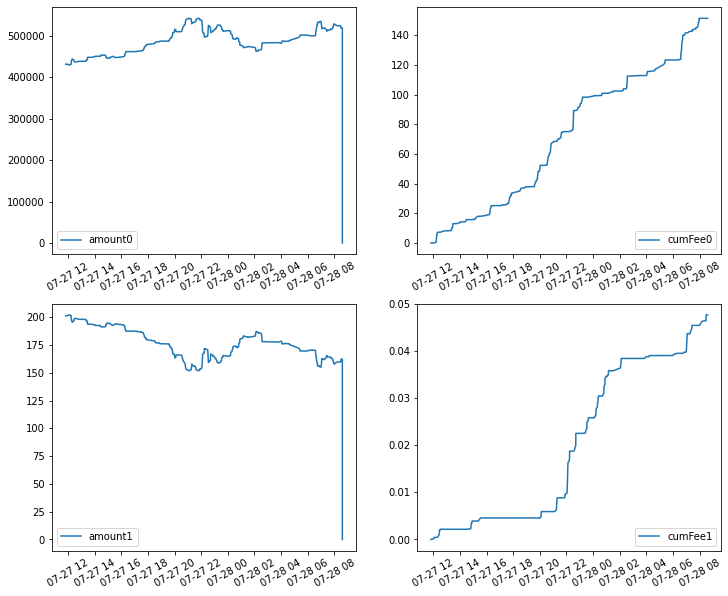

In [8]:
positions[5].get_balance(plain=True, draw_plot=True)

In [9]:
total_balance = report.total_balance(draw_plot=False, plain=True)
backtest_report = total_balance.copy(deep=True)

<AxesSubplot:title={'center':'Total Balance'}>

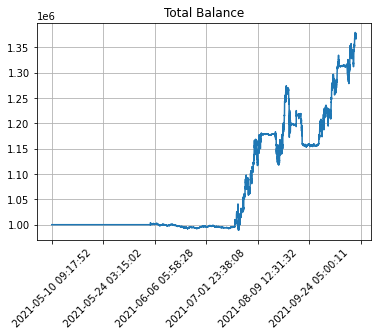

In [10]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0NoFee", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1NoFee", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True,title='Total Balance')
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')

In [11]:
eth_balance
eth_balance_df = pd.DataFrame(eth_balance)
eth_balance_df.columns = ['eth_balance']
eth_balance_df

,eth_balance
timestamp,
1620609472,0.000000
1620609830,0.000000
1620609889,0.000000
1620609894,0.000000
1620610623,0.000000
...,...
1636505114,578418.200326
1636505262,578616.405276
1636505287,578625.195163


In [12]:
usdc_balance
usdc_balance_df = pd.DataFrame(usdc_balance)
usdc_balance_df.columns = ['usdc_balance']
usdc_balance_df

,usdc_balance
timestamp,
1620609472,1000000.000000
1620609830,1000000.000000
1620609889,1000000.000000
1620609894,1000000.000000
1620610623,1000000.000000
...,...
1636505084,792401.056856
1636505114,790672.236884
1636505262,790414.699775


In [13]:
tb_Timing

2021-05-10 09:17:52    1.000000e+06
2021-05-10 09:23:50    1.000000e+06
2021-05-10 09:24:49    1.000000e+06
2021-05-10 09:24:54    1.000000e+06
2021-05-10 09:37:03    1.000000e+06
                           ...     
2021-11-10 08:45:14    1.369090e+06
2021-11-10 08:47:42    1.369031e+06
2021-11-10 08:48:07    1.369028e+06
2021-11-10 08:48:26    1.367105e+06
2021-11-10 08:48:53             NaN
Length: 118264, dtype: float64

# 计算绩效指标

In [14]:
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

2021-05-10    1.000000e+06
2021-05-11    1.000000e+06
2021-05-12    1.000000e+06
2021-05-13    1.000000e+06
2021-05-14    1.000000e+06
                  ...     
2021-11-06    1.320629e+06
2021-11-07    1.350647e+06
2021-11-08    1.371517e+06
2021-11-09    1.376035e+06
2021-11-10    1.367105e+06
Freq: D, Length: 185, dtype: float64

In [15]:
df_tb = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb['return'] = df_tb['close'].pct_change()
df_tb['return_2'] = df_tb['close']/df_tb['close'].shift(1) - 1
df_tb = df_tb.iloc[:-1,:]
df_tb

,close,return,return_2
2021-05-10,1.000000e+06,NaN,NaN
2021-05-11,1.000000e+06,0.000000,0.000000
2021-05-12,1.000000e+06,0.000000,0.000000
2021-05-13,1.000000e+06,0.000000,0.000000
2021-05-14,1.000000e+06,0.000000,0.000000
...,...,...,...
2021-11-05,1.332044e+06,-0.002685,-0.002685
2021-11-06,1.320629e+06,-0.008570,-0.008570
2021-11-07,1.350647e+06,0.022731,0.022731
2021-11-08,1.371517e+06,0.015451,0.015451


<AxesSubplot:>

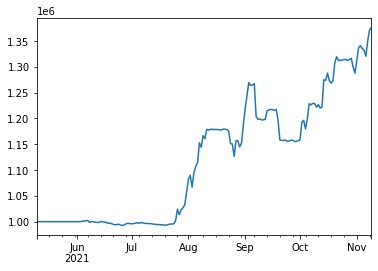

In [16]:
df_tb['close'].plot()

In [17]:
from scipy.stats.mstats import gmean
import math
def max_drawdown(df):
    """
    :return: Max drawdown of the financial series.
    """
    roll_max = df['close'].expanding().max()
    maxDrawdown = -1 * np.min(df['close'] / roll_max - 1)  # 计算得到最大回撤
    return maxDrawdown

def annual_return(df):
    """
    :return: Annual return.
    """
    annualReturn = gmean(df['return'].dropna() + 1) ** 365 - 1  # 得到年化收益率
    return annualReturn

def annual_std(df):
    """
    :return: The annual standard deviation.
    """
    dailyStd = df['return'].std()  # 得到日度波动率
    annualStd = dailyStd * math.sqrt(365)  # 得到年化波动率
    return annualStd

def sharpe_ratio(df):
    """
    :return:  Sharpe ratio.
    """
    annualReturn = annual_return(df)
    annualStd = annual_std(df)
    sharpeRatio = annualReturn / annualStd  # 得到夏普比
    return sharpeRatio

def calmar_ratio(df):
    """
    :return: Calmar ratio.
    """
    annualReturn = annual_return(df)
    maxDrawdown = max_drawdown(df)
    calmarRatio = annualReturn / maxDrawdown
    return calmarRatio

def max_drawdown_duration(df):
    """
    :return: Max Drawdown duration
    """
    xdate = df_tb.index.tolist()
    ycapital = df_tb['close'].tolist()
    duration = []
    tmp_max_capital = ycapital[0]
    for c in ycapital:
        if c >= tmp_max_capital:
            duration.append(0)
        else:
            duration.append(duration[-1]+1)
        tmp_max_capital = max(c, tmp_max_capital)
    MaxDDD = max(duration)
    endidx = np.argmax(duration)
    startidx = endidx - MaxDDD
#     print(xdate[startidx])
#     print(xdate[endidx])
    startD = xdate[startidx]
    endD = xdate[endidx]
#     return MaxDDD, startidx, endidx
    return MaxDDD, startD,endD
    


# 输出绩效

【SWAP_USDC_WETH_3000】

USDC手续费 6366.405428 ETH手续费(USDC计价) 8351.96131522707
***************************资金曲线绩效***************************
最大回撤 0.08991587546226087
最长回撤持续期 48 日 起始日期 2021-06-07 00:00:00 结束日期 2021-07-25 00:00:00
年化收益 0.8901721562550831
夏普比率 4.476713508324648
卡尔玛比率 9.900055487183712


<AxesSubplot:title={'center':'Total Balance'}>

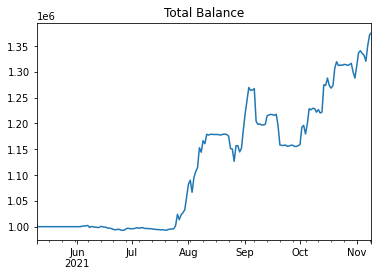

In [18]:
print('【SWAP_USDC_WETH_3000】')
print()

cumfee0 = backtest_report['cumFee0'].tolist()[-1]
cumfee1 = backtest_report['cumFee1'].tolist()[-1]/pricedata_res['price'].tolist()[-1]
print('USDC手续费',cumfee0,'ETH手续费(USDC计价)',cumfee1)
print('***************************资金曲线绩效***************************')
print('最大回撤',max_drawdown(df_tb))
print('最长回撤持续期',max_drawdown_duration(df_tb)[0],'日',
      '起始日期',max_drawdown_duration(df_tb)[1],
      '结束日期',max_drawdown_duration(df_tb)[2])
print('年化收益',annual_return(df_tb))
print('夏普比率',sharpe_ratio(df_tb))
print('卡尔玛比率',calmar_ratio(df_tb))
df_tb['close'].plot(title='Total Balance')